<a href="https://colab.research.google.com/github/jduell12/DS-Unit-2-Kaggle-Challenge/blob/main/C_guided_project_unit2_sprint2_module4ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification Metrics

- get and interpret the **confusion matrix** for classification models
- use classification metrics: **precision, recall**
- understand the relationships between precision, recall, **thresholds, and predicted probabilities**, to help **make decisions and allocate budgets**

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
from category_encoders import OrdinalEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# I. Wrangle Data

In [32]:
def wrangle(fm_path, tv_path=None):
  if tv_path:
    df = pd.merge(pd.read_csv(fm_path, na_values=[0, -2.000000e-08],parse_dates=['date_recorded']), pd.read_csv(tv_path)).set_index('id')
      # create new target
    df['needs_repair'] = (df['status_group'] != 'functional').astype(int)
    df.drop(columns='status_group', inplace=True)
  else:
    df = pd.read_csv(fm_path, na_values=[0, -2.000000e-08], parse_dates=['date_recorded'], index_col='id')
  # drop constant columns 
  df.drop(columns=['recorded_by'], inplace=True)
  # create age feature 
  df['pump_age'] = df['date_recorded'].dt.year - df['construction_year']
  df.drop(columns=['date_recorded'], inplace=True)
  # drop high cardinality columns 
  cutoff = 100
  drop_cols = [col for col in df.select_dtypes('object').columns if df[col].nunique() > 100]
  df.drop(columns = drop_cols, inplace=True)
  # drop duplicate columns 
  dup_cols = [col for col in df.head(15).T.duplicated().index if df.head(15).T.duplicated()[col]]
  df.drop(columns=dup_cols, inplace=True)

  return df

In [33]:
df = wrangle(DATA_PATH + 'waterpumps/train_features.csv', DATA_PATH + 'waterpumps/train_labels.csv')
X_test = wrangle(DATA_PATH + 'waterpumps/test_features.csv')

# EDA 
* How can we transform our target so that this is a **binary classification** problem?

In [6]:
df['status_group'].value_counts()
# functional --> doesn't need repair = 0 (negative class)
# non-functional or functional needs repair --> needs repair = 1 (positive class)

functional                 32259
non functional             22823
functional needs repair     4317
Name: status_group, dtype: int64

In [17]:
binary_target = OneHotEncoder(use_cat_names=True).fit_transform(df['status_group'])
binary_target.head(10)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,status_group_functional,status_group_non functional,status_group_functional needs repair
id,,,
69572.0,1,0,0
8776.0,1,0,0
34310.0,1,0,0
67743.0,0,1,0
19728.0,1,0,0
9944.0,1,0,0
19816.0,0,1,0
54551.0,0,1,0
53934.0,0,1,0


In [16]:
# df['needs_repair'] = (df['status_group'] != 'functional').astype(int)
df.head()

,amount_tsh,gps_height,longitude,latitude,num_private,basin,region,region_code,district_code,population,public_meeting,scheme_management,permit,construction_year,extraction_type,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,pump_age,needs_repair
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69572.0,6000.0,1390.0,34.938093,-9.856322,NaN,Lake Nyasa,Iringa,11,5.0,109.0,True,VWC,False,1999.0,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,12.0,0
8776.0,NaN,1399.0,34.698766,-2.147466,NaN,Lake Victoria,Mara,20,2.0,280.0,NaN,Other,True,2010.0,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,3.0,0
34310.0,25.0,686.0,37.460664,-3.821329,NaN,Pangani,Manyara,21,4.0,250.0,True,VWC,True,2009.0,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional,4.0,0
67743.0,NaN,263.0,38.486161,-11.155298,NaN,Ruvuma / Southern Coast,Mtwara,90,63.0,58.0,True,VWC,True,1986.0,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional,27.0,1
19728.0,NaN,NaN,31.130847,-1.825359,NaN,Lake Victoria,Kagera,18,1.0,NaN,True,NaN,True,NaN,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,NaN,0


# II. Split Data

In [34]:
# split TV / FM
target = 'needs_repair'
X = df.drop(columns=target)
y = df[target]

# train-val split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# sanity check
assert len(X_train) + len(X_val) == len(X)

# III. Establish Baseline

In [35]:
print('Baseline Accuracy:', y_train.value_counts(normalize=True).max())

Baseline Accuracy: 0.5425829668132747


# IV. Build Model

* OrdinalEncoder
* SimpleImputer
* RandomForestClassifier

In [36]:
model = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(
        n_estimators=50,
        n_jobs=-1,
        random_state=42
    )
)

model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'scheme_management', 'permit',
                                      'extraction_type',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'payment_type', 'water_quality',
                                      'quality_group', 'quantity', 'source',
                                      'source_type', 'source_class',
                                      'waterpoint_type',
                                      'waterpoint_type_group...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                 

# Interlude: Beware of leakage

If you leave 'status_group' in your feature matrix, you'll have **leakage**

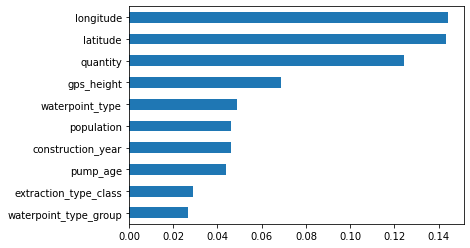

In [37]:
importances = model.named_steps['randomforestclassifier'].feature_importances_
features = X_train.columns
pd.Series(importances, index=features).sort_values().tail(10).plot(kind='barh')

# V Check Metrics

In [38]:
print('Training Accuracy:', model.score(X_train, y_train))
print('Validation Accuracy:', model.score(X_val, y_val))

Training Accuracy: 0.9949493886655864
Validation Accuracy: 0.8223905723905723


**Confusion Matrix**

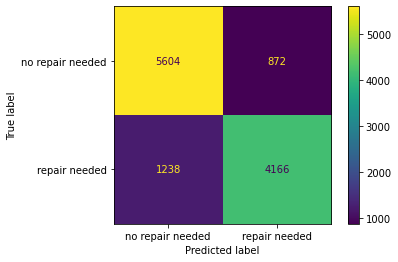

In [43]:
plot_confusion_matrix(
    model,
    X_val,
    y_val,
    display_labels=['no repair needed', 'repair needed'],
    values_format='.0f'
)

# yellow box = number of observation in validation set that we predicted correctly; True Negative
# green box = number of observations in validation set that we predicted correctly; True Positive 
# purple boxes = number of observations in validation set that we predicted incorrectly; False Negative, False Positive 

**Recall Score**

Of those pumps that actually needed repair, what proportion did you correctly predict as needing repair?

In [48]:
4166/(4166 + 1238)

0.7709104367135455

**Precision Score**

Of all the pumps that you predicted as needing repair, what proportion actually needed repair?

In [50]:
4166/(872 + 4166)

0.8269154426359666

**Classification Report**

In [54]:
print(classification_report(y_val, model.predict(X_val), target_names=['no repair needed', 'needs repair']))
#f1-score brings the precision and recall together into one variable

                  precision    recall  f1-score   support

no repair needed       0.82      0.87      0.84      6476
    needs repair       0.83      0.77      0.80      5404

        accuracy                           0.82     11880
       macro avg       0.82      0.82      0.82     11880
    weighted avg       0.82      0.82      0.82     11880



# Case Study

Let's say that it costs the Tanzanian government $100 to inspect a water pump and there is only funding for 2000 pump inspections. 

In [55]:
n_inspections = 2000

Scenario 1: Choose pumps randomly

In [68]:
y_val.value_counts(normalize=True)
# pumps needs repair 45% of the time 
repair_prob = y_val.value_counts(normalize=True).min()

print('Inspections conductions:', n_inspections)
print('Pumps repaired:', int(n_inspections * repair_prob))
print('Funds wasted:', int(n_inspections - (n_inspections * repair_prob))*100)

Inspections conductions: 2000
Pumps repaired: 909
Funds wasted: 109000


Scenario 2: Using our model 'out of the box'

In [70]:
data = {'y_val': y_val, 'y_pred': model.predict(X_val)}
results = pd.DataFrame(data)
results.head()

,y_val,y_pred
id,,
37098.0,1,1
14530.0,0,0
71755.0,0,0
55610.0,0,0
19821.0,0,0


In [72]:
mask = results['y_pred'] == 1
results[mask].head()

,y_val,y_pred
id,,
37098.0,1,1
12465.0,1,1
73562.0,1,1
9417.0,0,1
71514.0,1,1


In [74]:
sample = results[mask].sample(n_inspections)
sample.shape

(2000, 2)

In [76]:
sample.head(10)

,y_val,y_pred
id,,
25262.0,1,1
6147.0,1,1
61309.0,1,1
56574.0,1,1
64232.0,1,1
42515.0,1,1
4526.0,1,1
10895.0,0,1
11029.0,1,1


In [82]:
model.predict_proba(X_val)[:, -1]

array([1.  , 0.24, 0.  , ..., 0.  , 0.76, 0.54])

In [79]:
print('Inspections conductions:', n_inspections)
print('Pumps repaired:', sample['y_val'].sum())
print('Funds wasted:', int(n_inspections - (sample['y_val'].sum()))*100)

Inspections conductions: 2000
Pumps repaired: 1666
Funds wasted: 33400


Scenario 3: We emphasize **precision** in our model, and only select pumps that our model is very certain (>0.85) needs repair

In [84]:
data3 = {'y_val': y_val, 'y_pred_proba':model.predict_proba(X_val)[:, -1]}
results3 = pd.DataFrame(data3)
results3.head()

,y_val,y_pred_proba
id,,
37098.0,1,1.00
14530.0,0,0.24
71755.0,0,0.00
55610.0,0,0.48
19821.0,0,0.00


In [87]:
threshold = 0.85 
mask3 = results3['y_pred_proba'] > 0.85
sample3 = results3[mask3].sample(n_inspections)
sample3.head()

,y_val,y_pred_proba
id,,
52811.0,1,1.00
993.0,0,0.94
28342.0,1,1.00
53404.0,1,1.00
47172.0,1,0.98


In [88]:
print('Inspections conductions:', n_inspections)
print('Pumps repaired:', sample3['y_val'].sum())
print('Funds wasted:', int(n_inspections - (sample3['y_val'].sum()))*100)

Inspections conductions: 2000
Pumps repaired: 1885
Funds wasted: 11500
